<a href="https://colab.research.google.com/github/takao8/MLTSA_JClifford/blob/master/HW8/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PHYS667 HW8 by Jon Clifford

A lot of the initial code in this homework can be skipped over, as it involves retrieving the data and then preparing for the analysis.

# Initial Preperation

In [0]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd /content/gdrive/My\ Drive/MLTSA2020/

/content/gdrive/My Drive/MLTSA2020


In [0]:
!wget https://losc.ligo.org/s/events/LOSC_Event_tutorial.zip

--2020-04-29 19:04:12--  https://losc.ligo.org/s/events/LOSC_Event_tutorial.zip
Resolving losc.ligo.org (losc.ligo.org)... 131.215.113.73
Connecting to losc.ligo.org (losc.ligo.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gw-openscience.org/s/events/LOSC_Event_tutorial.zip [following]
--2020-04-29 19:04:12--  https://www.gw-openscience.org/s/events/LOSC_Event_tutorial.zip
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17430588 (17M) [application/zip]
Saving to: ‘LOSC_Event_tutorial.zip’

LOSC_Event_tutorial 100%[===================>]  16.62M  32.5MB/s    in 0.5s    

2020-04-29 19:04:13 (32.5 MB/s) - ‘LOSC_Event_tutorial.zip’ saved [17430588/17430588]



In [0]:
!unzip LOSC_Event_tutorial

Archive:  LOSC_Event_tutorial.zip
   creating: LOSC_Event_tutorial/
   creating: LOSC_Event_tutorial/.ipynb_checkpoints/
  inflating: LOSC_Event_tutorial/.ipynb_checkpoints/LOSC_Event_tutorial-checkpoint.ipynb  
  inflating: LOSC_Event_tutorial/BBH_events_v3.json  
  inflating: LOSC_Event_tutorial/GW150914_4_template.hdf5  
  inflating: LOSC_Event_tutorial/GW151226_4_template.hdf5  
  inflating: LOSC_Event_tutorial/GW170104_4_template.hdf5  
  inflating: LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5  
  inflating: LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5  
  inflating: LOSC_Event_tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5  
  inflating: LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5  
  inflating: LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5  
  inflating: LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5  
  inflating: LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5  
  inflating: LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5  
  

In [0]:
!pip install h5py

In [0]:
#-- SET ME   Tutorial should work with most binary black hole events
#-- Default is no event selection; you MUST select one to proceed.
eventname = ''
eventname = 'GW150914' 
eventname1 = 'GW151226' 
eventname2 = 'LVT151012'
eventname3 = 'GW170104'

# want plots?
make_plots = 1
plottype = "png"
#plottype = "pdf"

In [0]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
LIGOpath = 'LOSC_Event_tutorial'
import sys
sys.path.insert(0, LIGOpath)
import readligo as rl

# you might get a matplotlib warning here; you can ignore it.

# Reading Event Properties from json file

In [0]:
# Read the event properties from a local json file
fnjson = LIGOpath + "/BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()


In [0]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
tevent = event['tevent']            # Set approximate event GPS time


In [0]:
fs = event['fs']                    # Set sampling rate
fband = event['fband']              # frequency band for bandpassing signal

In [0]:
print("Reading in parameters for event " + event["name"])
print(event)

Reading in parameters for event GW150914
{'name': 'GW150914', 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5', 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5', 'fn_template': 'GW150914_4_template.hdf5', 'fs': 4096, 'tevent': 1126259462.44, 'utcevent': '2015-09-14T09:50:45.44', 'm1': 41.743, 'm2': 29.237, 'a1': 0.355, 'a2': -0.769, 'approx': 'lalsim.SEOBNRv2', 'fband': [43.0, 300.0], 'f_min': 10.0}


# Read the Actual Data

Here we'll finally analyze the data given to us.  We'll be looking at the time series around when the gravitational wave event occured.

In [0]:

#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(LIGOpath + "/" + fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(LIGOpath + "/" + fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()
#strain_H1, time_H1, chan_dict_H1

LOSC_Event_tutorial/readligo.py:138: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  shortnameArray = dqInfo['DQShortnames'].value
LOSC_Event_tutorial/readligo.py:144: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  injnameArray = injInfo['InjShortnames'].value
LOSC_Event_tutorial/readligo.py:149: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  gpsStart = meta['GPSstart'].value


In [0]:
# both H1 and L1 will have the same time vector, so:
time = time_H1

# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))

time_H1: len, min, mean, max =  131072 1126259446.0 1126259461.999878 1126259477.9997559
strain_H1: len, min, mean, max =  131072 -7.044665943156067e-19 5.895522509246437e-23 7.706262192397465e-19
strain_L1: len, min, mean, max =  131072 -1.8697138664279764e-18 -1.0522332249909908e-18 -4.60035111311666e-20
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA


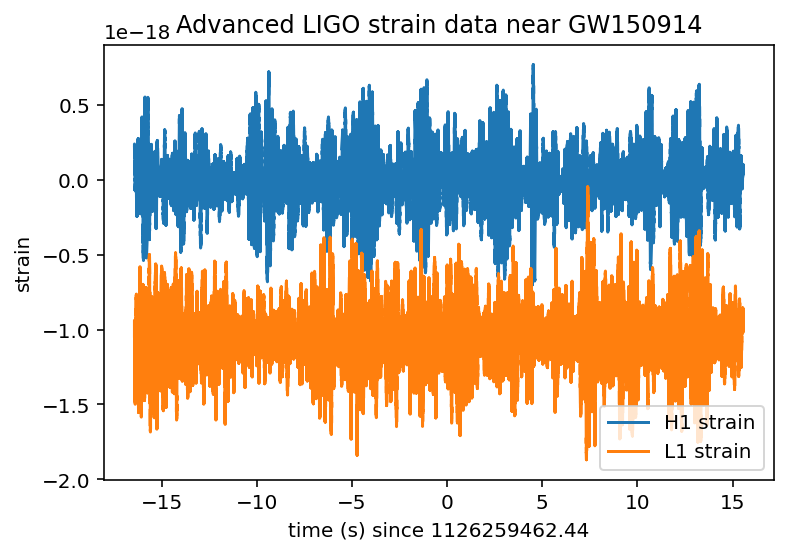

In [0]:
# plot the whole time series :
# index into the strain time series for this time interval:


if make_plots:
    plt.figure()
    plt.plot(time-tevent,strain_H1,label='H1 strain')
    plt.plot(time-tevent,strain_L1,label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_strain.'+plottype)

Figure 1: Plot of the H1 (Hanford) and L1 (Livingston) strains over time.  These series are signal of the LIGO detectors in two different areas, whose analysis led to the verification of the existence of gravitational waves.

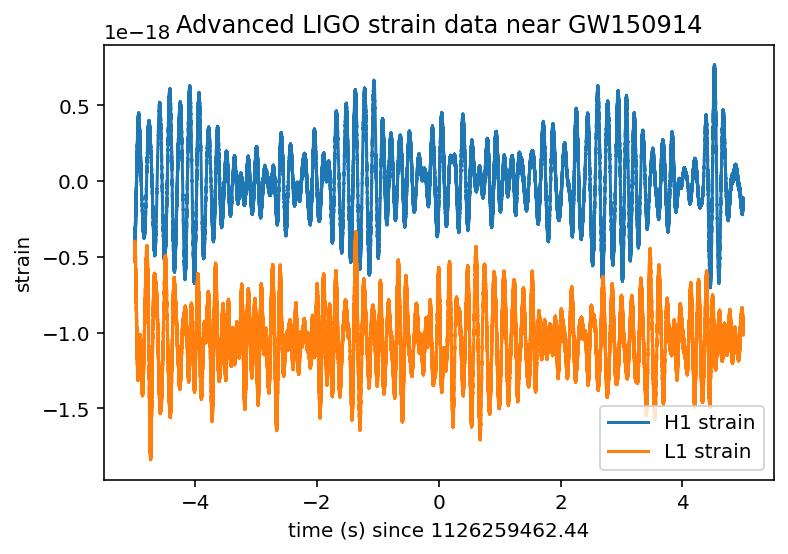

In [0]:
# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

if make_plots:
    plt.figure()
    plt.plot(time[indxt]-tevent,strain_H1[indxt],label='H1 strain')
    plt.plot(time[indxt]-tevent,strain_L1[indxt],label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_strain.'+plottype)

Figure 2: Same as figure 1, just windowed specifically around the time of our event.

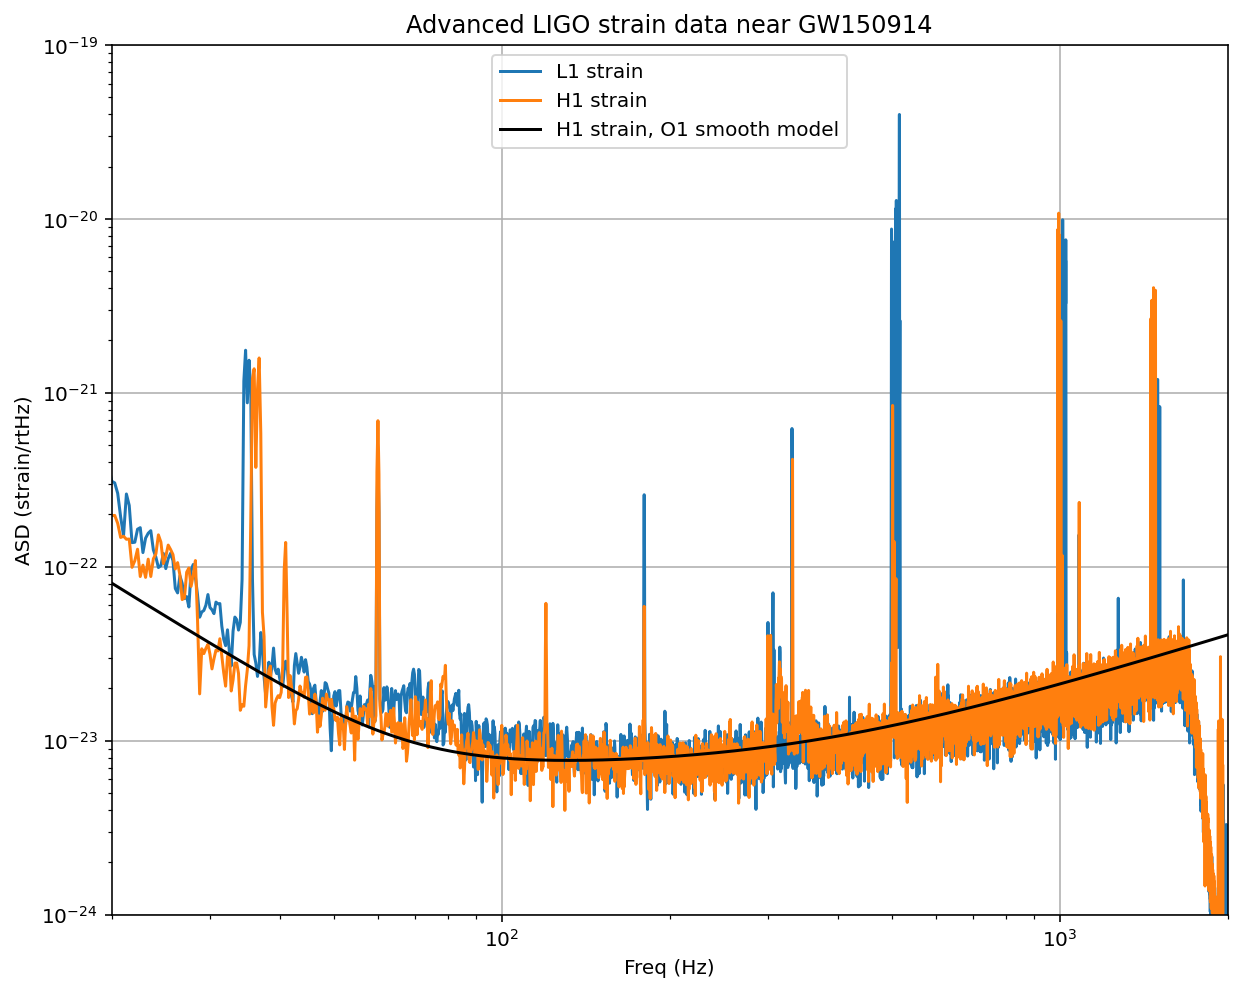

In [0]:
make_psds = 1
if make_psds:
    # number of sample for the fast fourier transform:
    NFFT = 4 * fs
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)

    # Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    psd_smooth = interp1d(freqs, Pxx)

if make_plots:
    # plot the ASDs, with the template overlaid:
    f_min = 20.
    f_max = 2000. 
    plt.figure(figsize=(10,8))
    plt.loglog(freqs, np.sqrt(Pxx_L1),label='L1 strain')
    plt.loglog(freqs, np.sqrt(Pxx_H1),label='H1 strain')
    plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')
    plt.axis([f_min, f_max, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_ASDs.'+plottype)

Figure 3: The result of taking the Amplitude Spectral Density of both the H1 and L1 strains.  We would normally desire this to come out as white noise, but obviously appears to be skewed.  As with fourier transforms, we want to be able to extract the signal out of this band.  To do this, we'll continue below by whitening this signal and reanalyzing its shape.

# Plotting the whitened signals

We have noise in our fourier transformed signal, and we want to be able to transform it into white noise.

In [0]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    freqs1 = np.linspace(0,2048., int(Nt/2+1))
    

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm  # note the interpolated psd
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

whiten_data = 1
if whiten_data:

    # now whiten the data from H1 and L1, and the template (use H1 PSD):
    strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
    strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
    # We need to suppress the high frequency noise (no signal!) with some bandpassing:
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization
    strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten) / normalization


Text(0, 0.5, 'sigmas from mean')

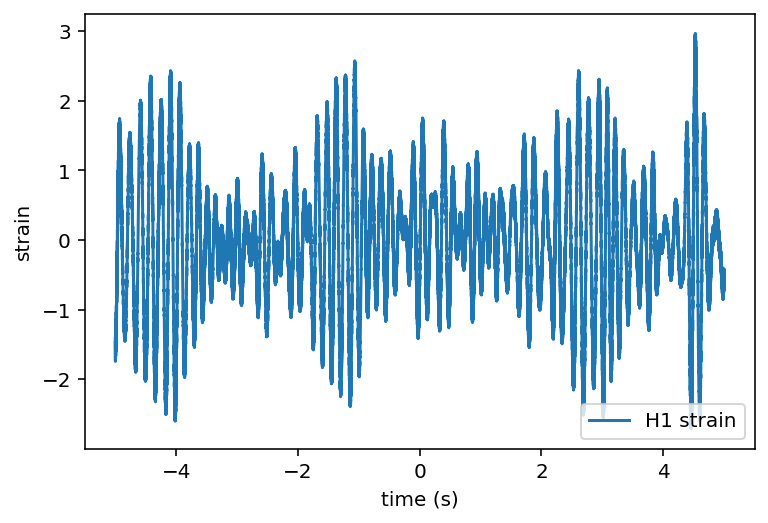

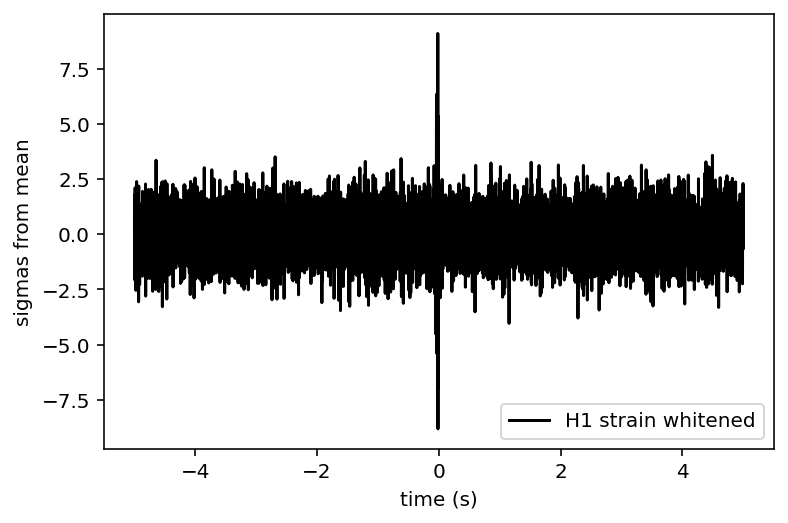

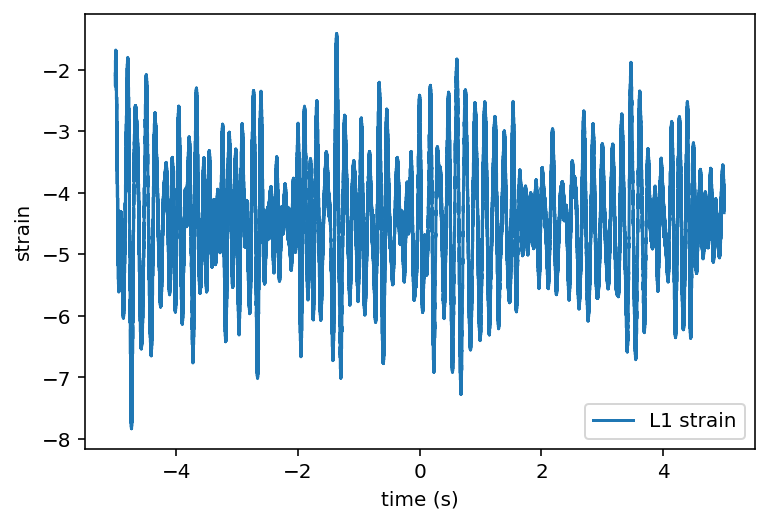

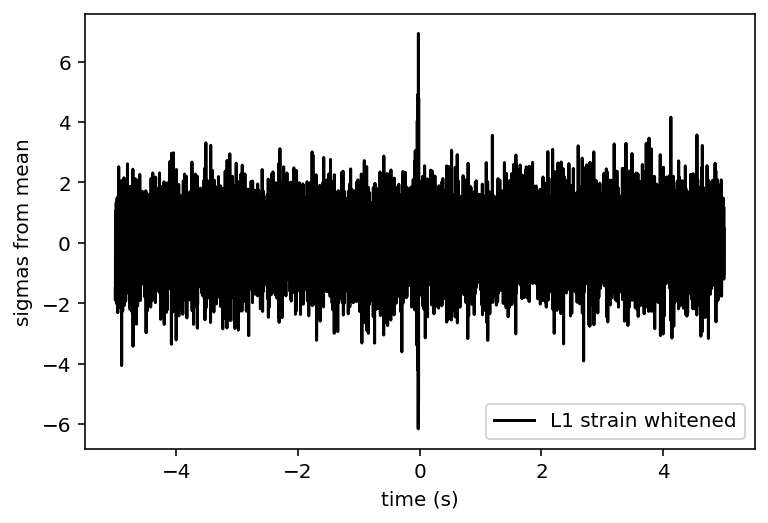

In [0]:

indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
plt.figure()
plt.plot(time[indxt]-tevent,strain_H1[indxt]/strain_H1[indxt].std(),label='H1 strain')
plt.legend(loc="lower right")
plt.xlabel('time (s)')
plt.ylabel('strain')
plt.figure()
plt.plot(time[indxt]-tevent,strain_H1_whitenbp[indxt]/strain_H1_whitenbp[indxt].std(), c='k', label='H1 strain whitened')
plt.legend(loc='lower right')
plt.xlabel('time (s)')
plt.ylabel('sigmas from mean')

plt.figure()
plt.plot(time[indxt]-tevent,strain_L1[indxt]/strain_L1[indxt].std(),label='L1 strain')
plt.legend(loc="lower right")
plt.xlabel('time (s)')
plt.ylabel('strain')
plt.figure()
plt.plot(time[indxt]-tevent,strain_L1_whitenbp[indxt]/strain_L1_whitenbp[indxt].std(), c='k', label='L1 strain whitened')
plt.legend(loc='lower right')
plt.xlabel('time (s)')
plt.ylabel('sigmas from mean')

Figure 4: Plots of the original strains (blue) and the whitened series (black).  The whitening process is as follows: We take our strain, perform a fast fourier transform on it, then divide it by the (interpolated) square root psd, then transform back into our time domain.  This returns our whitened series, as desired.  Note that our whitened series now has a spike in the middle, and otherwise appears completely engulfed by white noise.

**==>Do not do bp just whitened**

**==> what's the difference between non-whitened and whitened signal?**

In [0]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(LIGOpath + "/" + fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()


Properties of waveform template in GW150914_4_template.hdf5
Waveform family = b'lalsim.SEOBNRv2'
Masses = 41.74, 29.24 Msun
Mtot = 70.98 Msun, mfinal = 67.43 Msun 
Spins = 0.35, -0.77
Freq at inband, peak = 43.05, 169.84 Hz
Time at inband, peak = -0.08, -0.02 s
Duration (s) inband-peak = 0.06 s
N_cycles inband-peak = 4
v/c at peak = 0.57
Radius of final BH = 199 km


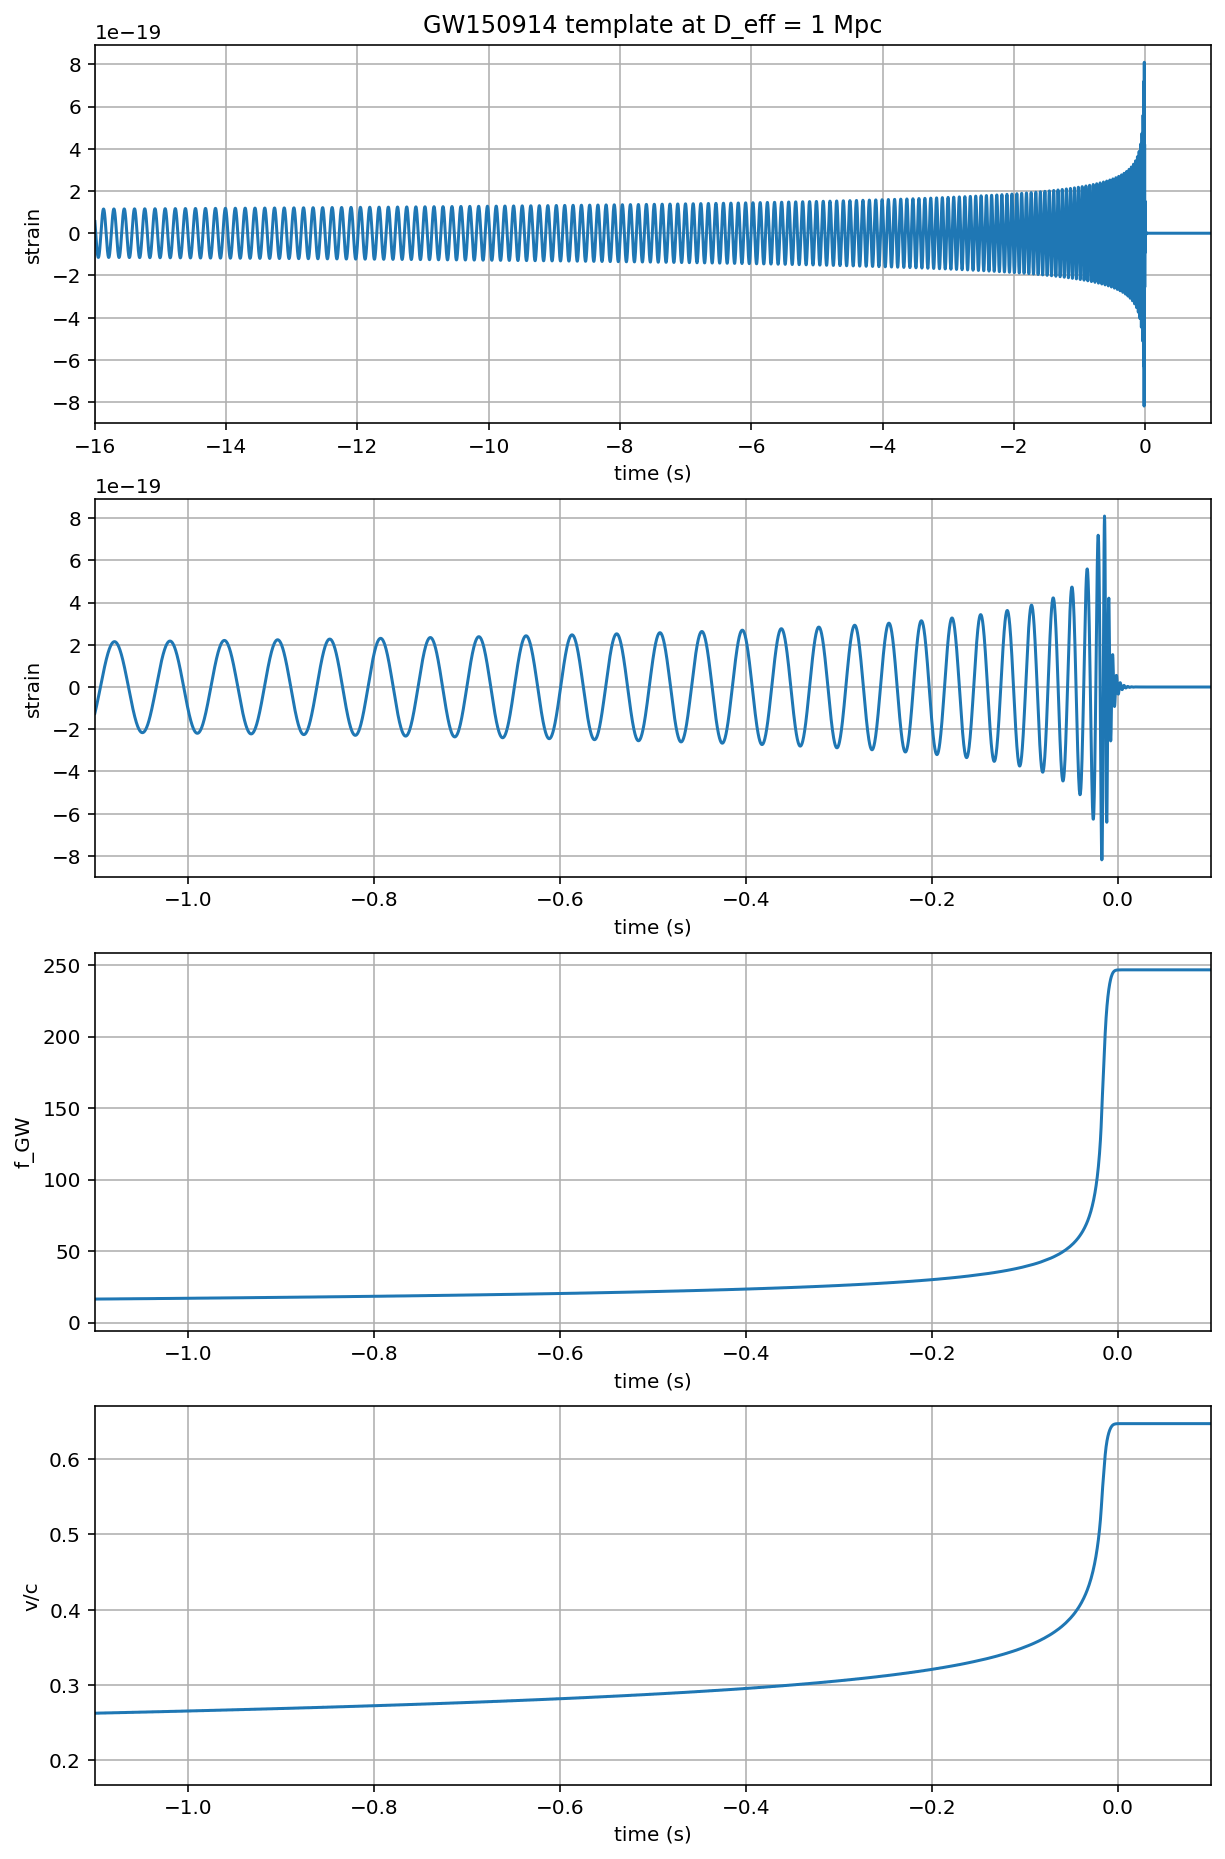

In [0]:
# extract metadata from the template file:
template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

# whiten the templates:
template_p_whiten = whiten(template_p,psd_H1,dt)
template_c_whiten = whiten(template_c,psd_H1,dt)
template_p_whitenbp = filtfilt(bb, ab, template_p_whiten) / normalization
template_c_whitenbp = filtfilt(bb, ab, template_c_whiten) / normalization

# Compute, print and plot some properties of the template:

# constants:
clight = 2.99792458e8                # m/s
G = 6.67259e-11                      # m^3/kg/s^2 
MSol = 1.989e30                      # kg

# template parameters: masses in units of MSol:
t_mtot = t_m1+t_m2
# final BH mass is typically 95% of the total initial mass:
t_mfin = t_mtot*0.95
# Final BH radius, in km:
R_fin = 2*G*t_mfin*MSol/clight**2/1000.

# complex template:
template = (template_p + template_c*1.j) 
ttime = time-time[0]-template_offset

# compute the instantaneous frequency of this chirp-like signal:
tphase = np.unwrap(np.angle(template))
fGW = np.gradient(tphase)*fs/(2.*np.pi)
# fix discontinuities at the very end:
# iffix = np.where(np.abs(np.gradient(fGW)) > 100.)[0]
iffix = np.where(np.abs(template) < np.abs(template).max()*0.001)[0]
fGW[iffix] = fGW[iffix[0]-1]
fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]

# compute v/c:
voverc = (G*t_mtot*MSol*np.pi*fGW/clight**3)**(1./3.)

# index where f_GW is in-band:
f_inband = fband[0]
iband = np.where(fGW > f_inband)[0][0]
# index at the peak of the waveform:
ipeak = np.argmax(np.abs(template))

# number of cycles between inband and peak:
Ncycles = (tphase[ipeak]-tphase[iband])/(2.*np.pi)

print('Properties of waveform template in {0}'.format(fn_template))
print("Waveform family = {0}".format(t_approx))
print("Masses = {0:.2f}, {1:.2f} Msun".format(t_m1,t_m2))
print('Mtot = {0:.2f} Msun, mfinal = {1:.2f} Msun '.format(t_mtot,t_mfin))
print("Spins = {0:.2f}, {1:.2f}".format(t_a1,t_a2))
print('Freq at inband, peak = {0:.2f}, {1:.2f} Hz'.format(fGW[iband],fGW[ipeak]))
print('Time at inband, peak = {0:.2f}, {1:.2f} s'.format(ttime[iband],ttime[ipeak]))
print('Duration (s) inband-peak = {0:.2f} s'.format(ttime[ipeak]-ttime[iband]))
print('N_cycles inband-peak = {0:.0f}'.format(Ncycles))
print('v/c at peak = {0:.2f}'.format(voverc[ipeak]))
print('Radius of final BH = {0:.0f} km'.format(R_fin))

if make_plots:
    plt.figure(figsize=(10,16))
    plt.subplot(4,1,1)
    plt.plot(ttime,template_p)
    plt.xlim([-template_offset,1.])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    plt.title(eventname+' template at D_eff = 1 Mpc')
    
    plt.subplot(4,1,2)
    plt.plot(ttime,template_p)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    #plt.title(eventname+' template at D_eff = 1 Mpc')
    
    plt.subplot(4,1,3)
    plt.plot(ttime,fGW)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('f_GW')
    #plt.title(eventname+' template f_GW')
    
    plt.subplot(4,1,4)
    plt.plot(ttime,voverc)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('v/c')
    #plt.title(eventname+' template v/c')
    plt.savefig(eventname+'_template.'+plottype)

Figure 5: Plots of our template with its specific physical properties.  As far as I understand, the theoretical work shows what the signal should look like (as shown here), so that we may match it with an incoming signal.  These plots illustrate the properties of the signal we are looking for.

Below we fit the actual signal.

For detector H1, maximum at 1126259462.4395 with SNR = 18.6, D_eff = 814.44, horizon = 1889.6 Mpc
For detector L1, maximum at 1126259462.4324 with SNR = 13.2, D_eff = 999.74, horizon = 1650.6 Mpc


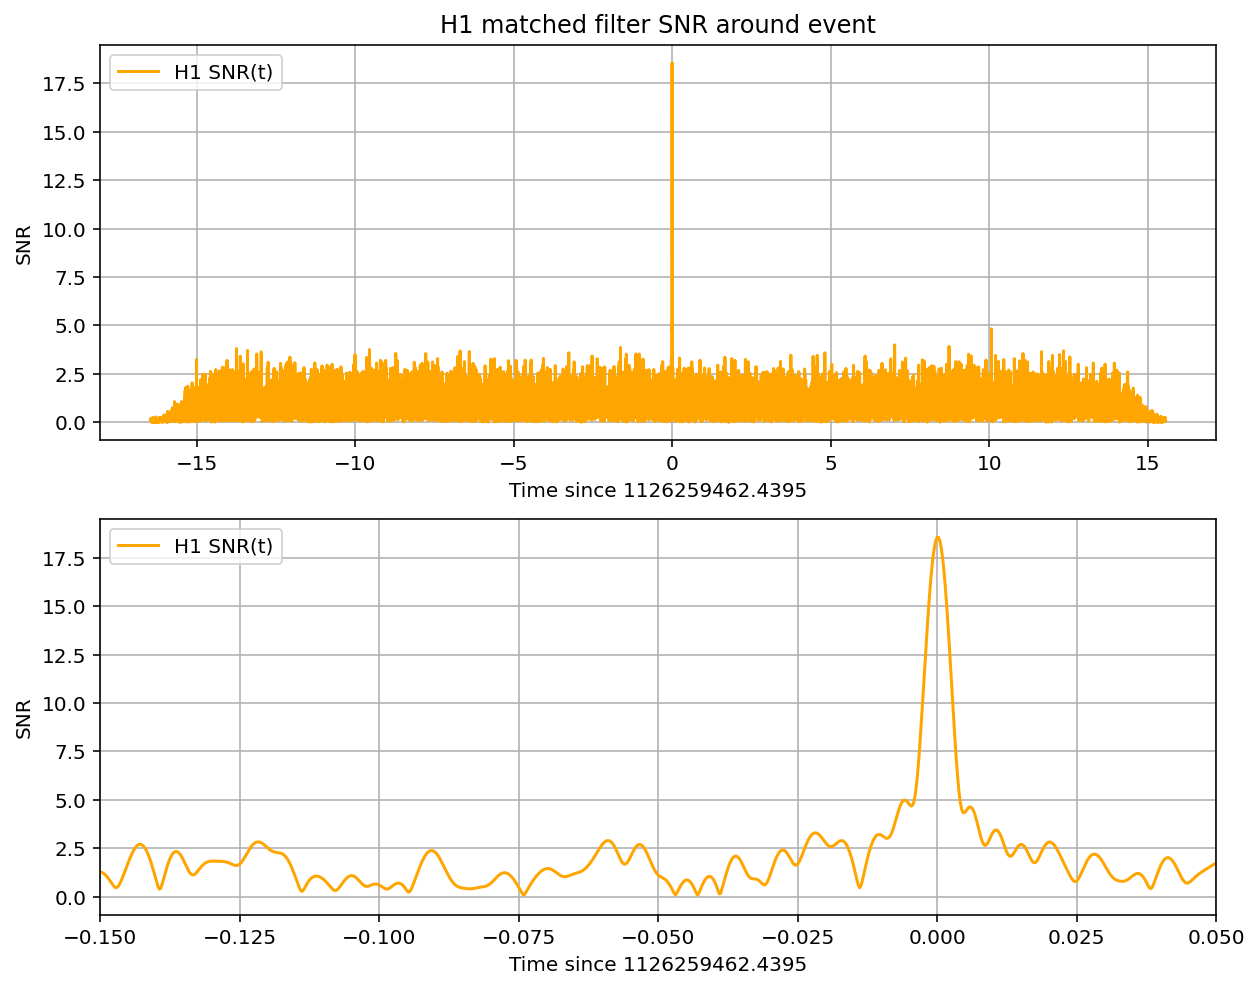

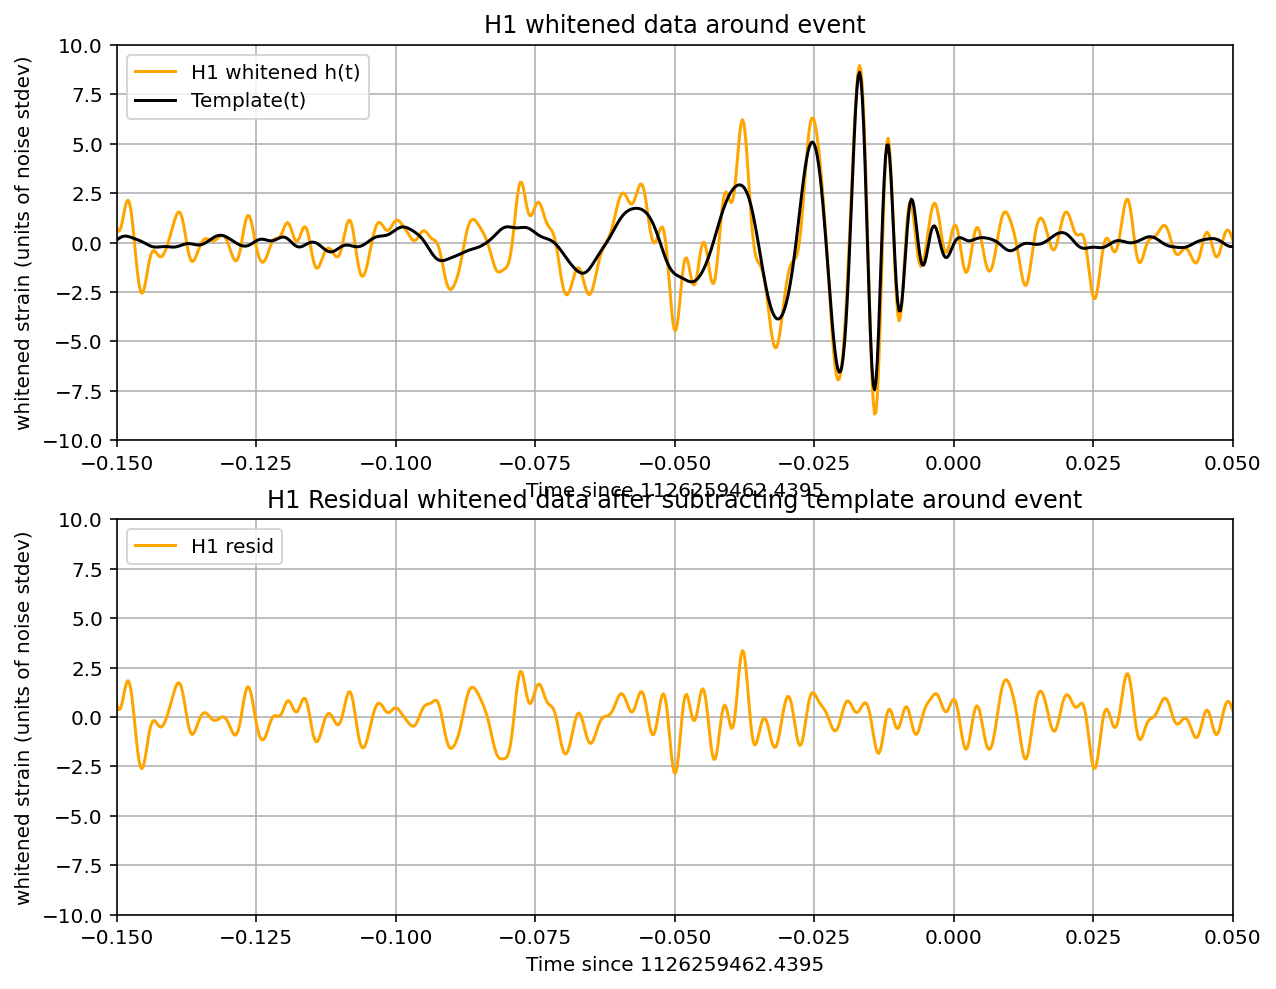

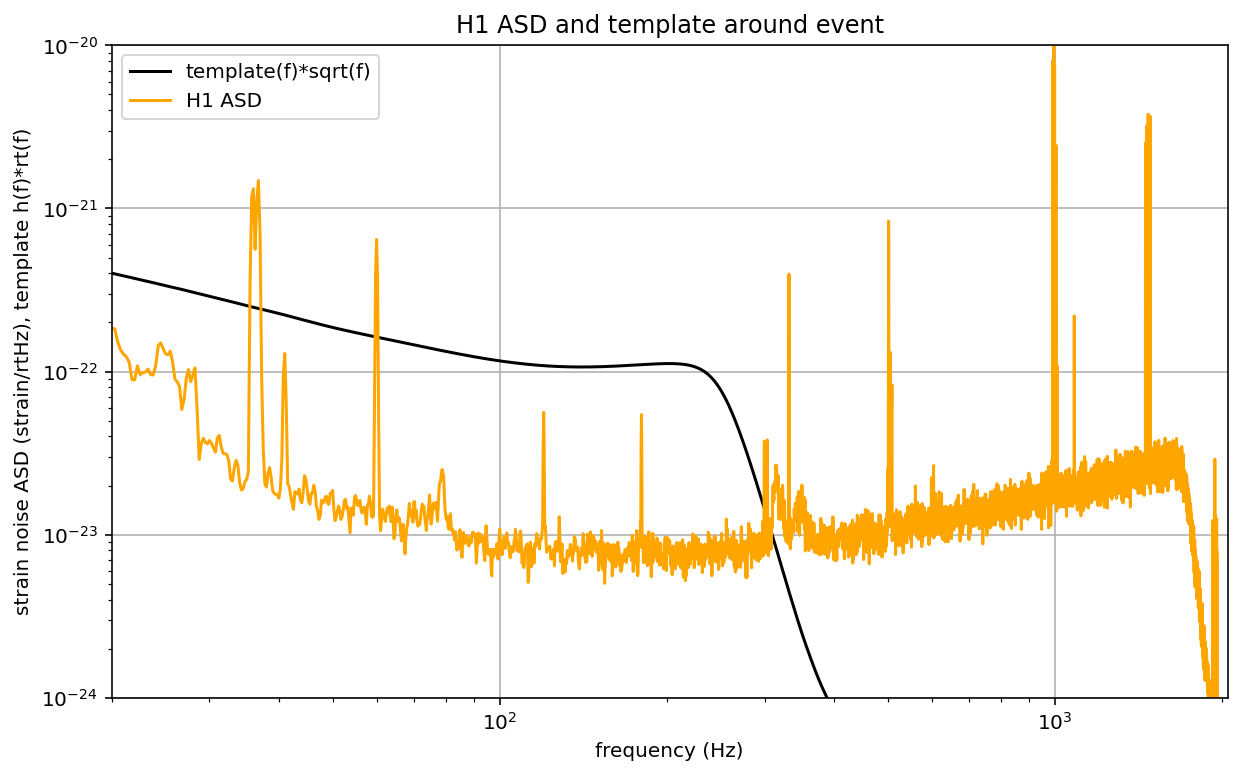

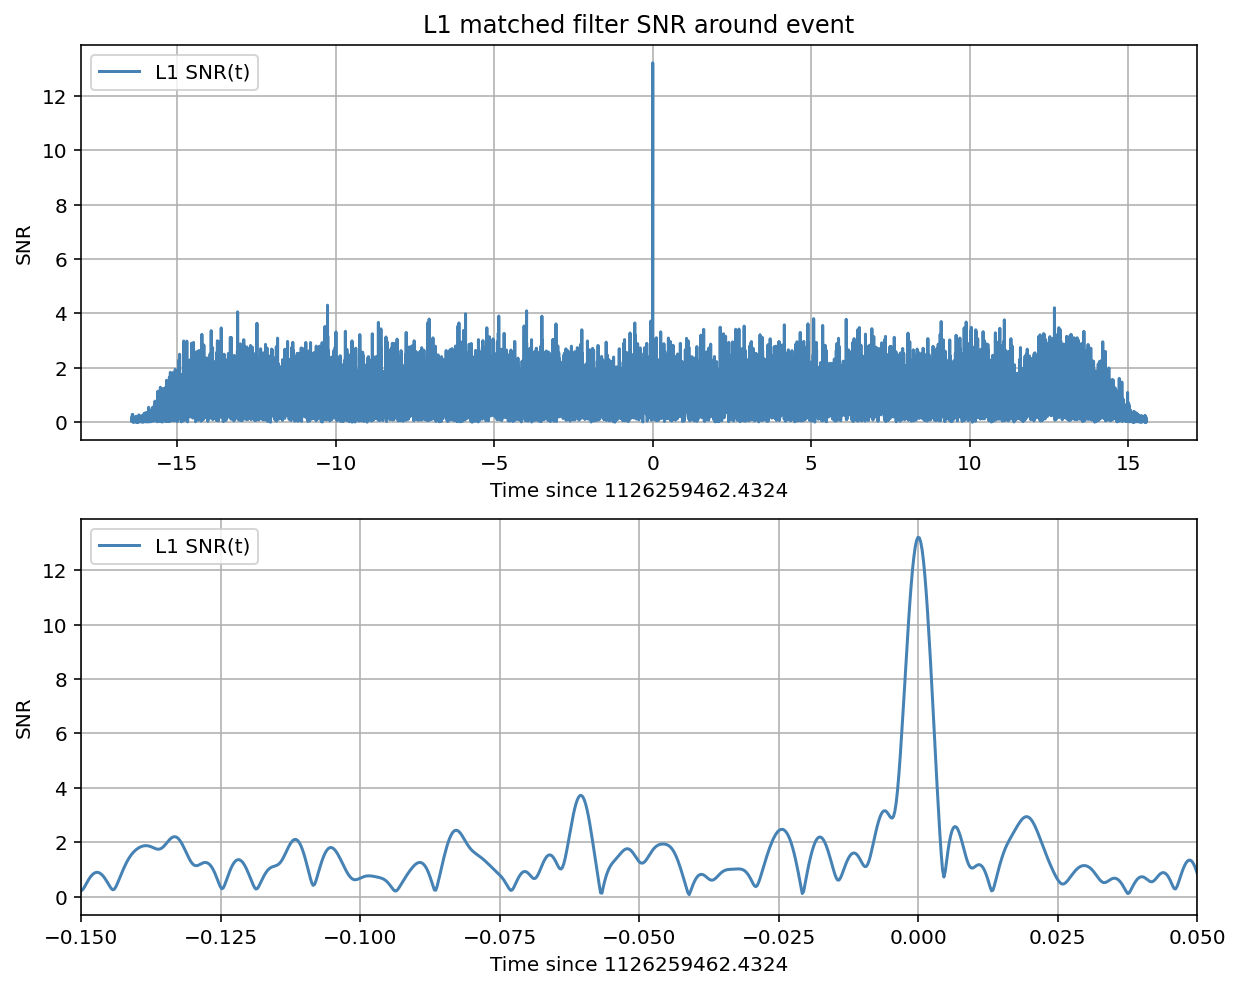

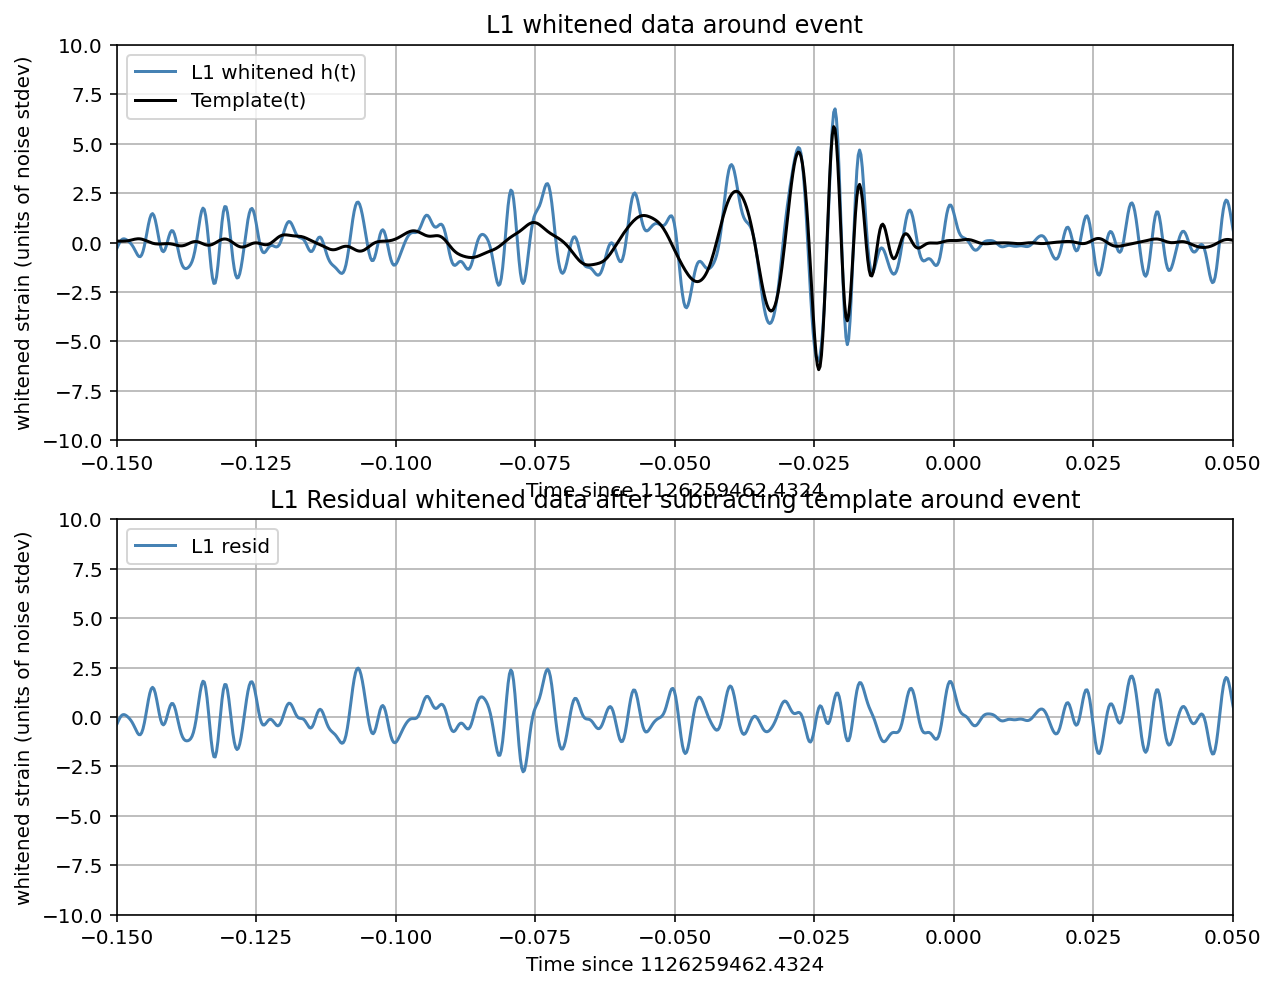

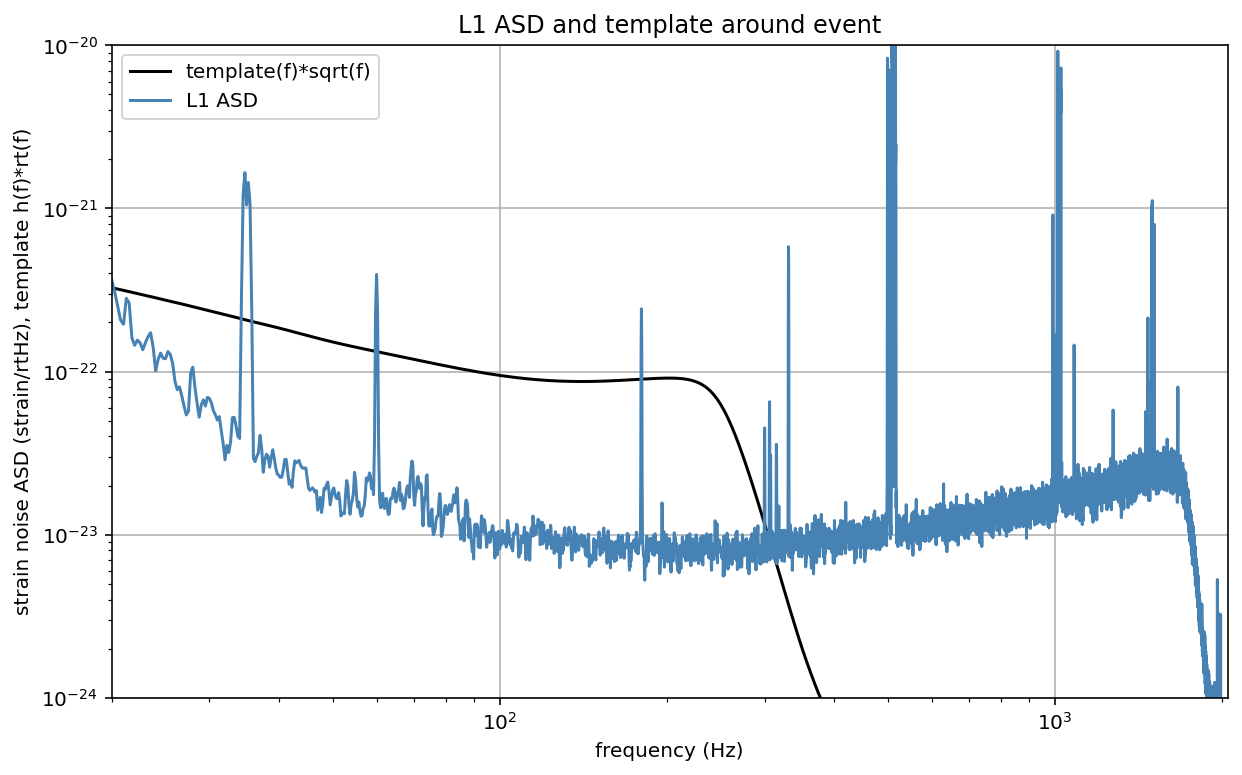

In [0]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(LIGOpath + "/" + fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()
    
# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# define the complex template, common to both detectors:
template = (template_p + template_c*1.j) 
# We will record the time where the data match the END of the template.
etime = time+template_offset
# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs

# loop over the detectors
dets = ['H1', 'L1']
for det in dets:

    if det is 'L1': data = strain_L1.copy()
    else:           data = strain_H1.copy()

    # -- Calculate the PSD of the data.  Also use an overlap, and window:
    data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(data*dwindow) / fs

    # -- Interpolate to get the PSD values at the needed frequencies
    power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = time[indmax]
    SNRmax = SNR[indmax]

    # Calculate the "effective distance" (see FINDCHIRP paper for definition)
    # d_eff = (8. / SNRmax)*D_thresh
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)

    # apply time offset, phase, and d_eff to template 
    template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
    template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude
    
    # Whiten and band-pass the template for plotting
    template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
    template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template
    
    print('For detector {0}, maximum at {1:.4f} with SNR = {2:.1f}, D_eff = {3:.2f}, horizon = {4:0.1f} Mpc' 
          .format(det,timemax,SNRmax,d_eff,horizon))

    if make_plots:

        # plotting changes for the detectors:
        if det is 'L1': 
            pcolor='SteelBlue'
            strain_whitenbp = strain_L1_whitenbp
            template_L1 = template_match.copy()
        else:
            pcolor='Orange'
            strain_whitenbp = strain_H1_whitenbp
            template_H1 = template_match.copy()

        # -- Plot the result
        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.plot(time-timemax, SNR, pcolor,label=det+' SNR(t)')
        #plt.ylim([0,25.])
        plt.grid('on')
        plt.ylabel('SNR')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.legend(loc='upper left')
        plt.title(det+' matched filter SNR around event')

        # zoom in
        plt.subplot(2,1,2)
        plt.plot(time-timemax, SNR, pcolor,label=det+' SNR(t)')
        plt.grid('on')
        plt.ylabel('SNR')
        plt.xlim([-0.15,0.05])
        #plt.xlim([-0.3,+0.3])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.legend(loc='upper left')
        plt.savefig(eventname+"_"+det+"_SNR."+plottype)

        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.plot(time-tevent,strain_whitenbp,pcolor,label=det+' whitened h(t)')
        plt.plot(time-tevent,template_match,'k',label='Template(t)')
        plt.ylim([-10,10])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left')
        plt.title(det+' whitened data around event')

        plt.subplot(2,1,2)
        plt.plot(time-tevent,strain_whitenbp-template_match,pcolor,label=det+' resid')
        plt.ylim([-10,10])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left')
        plt.title(det+' Residual whitened data after subtracting template around event')
        plt.savefig(eventname+"_"+det+"_matchtime."+plottype)
                 
        # -- Display PSD and template
        # must multiply by sqrt(f) to plot template fft on top of ASD:
        plt.figure(figsize=(10,6))
        template_f = np.absolute(template_fft)*np.sqrt(np.abs(datafreq)) / d_eff
        plt.loglog(datafreq, template_f, 'k', label='template(f)*sqrt(f)')
        plt.loglog(freqs, np.sqrt(data_psd),pcolor, label=det+' ASD')
        plt.xlim(20, fs/2)
        plt.ylim(1e-24, 1e-20)
        plt.grid()
        plt.xlabel('frequency (Hz)')
        plt.ylabel('strain noise ASD (strain/rtHz), template h(f)*rt(f)')
        plt.legend(loc='upper left')
        plt.title(det+' ASD and template around event')
        plt.savefig(eventname+"_"+det+"_matchfreq."+plottype)


Figure 6: Performing the event detection on H1 and L1 using our match filtering.  An important note is how an attempt to use match filtering on non-whitened data causes a poor fit, as shown in the bottom graphs for both H1 and L1.  Overall, the event was successfully detected with the algorithm, as shown in the fit in the whitened data for both H1 and L1.

# Doing it for different template and Livingston event LVT151012

Now we'll do what we did before, just with a different event. Results should look the same.

In [0]:
eventname = 'LVT151012'

In [0]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
tevent = event['tevent']            # Set approximate event GPS time

In [0]:
fs = event['fs']                    # Set sampling rate
fband = event['fband']              # frequency band for bandpassing signal

# Inserting everything else

In [180]:

#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(LIGOpath + "/" + fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(LIGOpath + "/" + fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()

LOSC_Event_tutorial/readligo.py:138: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  shortnameArray = dqInfo['DQShortnames'].value
LOSC_Event_tutorial/readligo.py:144: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  injnameArray = injInfo['InjShortnames'].value
LOSC_Event_tutorial/readligo.py:149: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  gpsStart = meta['GPSstart'].value


In [181]:
# both H1 and L1 will have the same time vector, so:
time = time_H1

# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))

time_H1: len, min, mean, max =  131072 1128678884.0 1128678899.999878 1128678915.9997559
strain_H1: len, min, mean, max =  131072 -8.590827401770376e-19 -2.8934952956460883e-22 8.437113739365321e-19
strain_L1: len, min, mean, max =  131072 -3.880397433260277e-18 -1.0955608636862195e-18 1.8973107919644716e-18
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA


In [0]:
make_psds = 1
if make_psds:
    # number of sample for the fast fourier transform:
    NFFT = 4 * fs
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)

    # Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    psd_smooth = interp1d(freqs, Pxx)

In [0]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    freqs1 = np.linspace(0,2048., int(Nt/2+1))
    

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm  # note the interpolated psd
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

whiten_data = 1
if whiten_data:

    # now whiten the data from H1 and L1, and the template (use H1 PSD):
    strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
    strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
    # We need to suppress the high frequency noise (no signal!) with some bandpassing:
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization
    strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten) / normalization


# Looking at the template and doing the analysis

Properties of waveform template in LVT151012_4_template.hdf5
Waveform family = b'lalsim.SEOBNRv2'
Masses = 44.11, 11.21 Msun
Mtot = 55.32 Msun, mfinal = 52.55 Msun 
Spins = 0.45, -0.43
Freq at inband, peak = 43.01, 210.68 Hz
Time at inband, peak = -0.18, -0.00 s
Duration (s) inband-peak = 0.18 s
N_cycles inband-peak = 11
v/c at peak = 0.56
Radius of final BH = 155 km


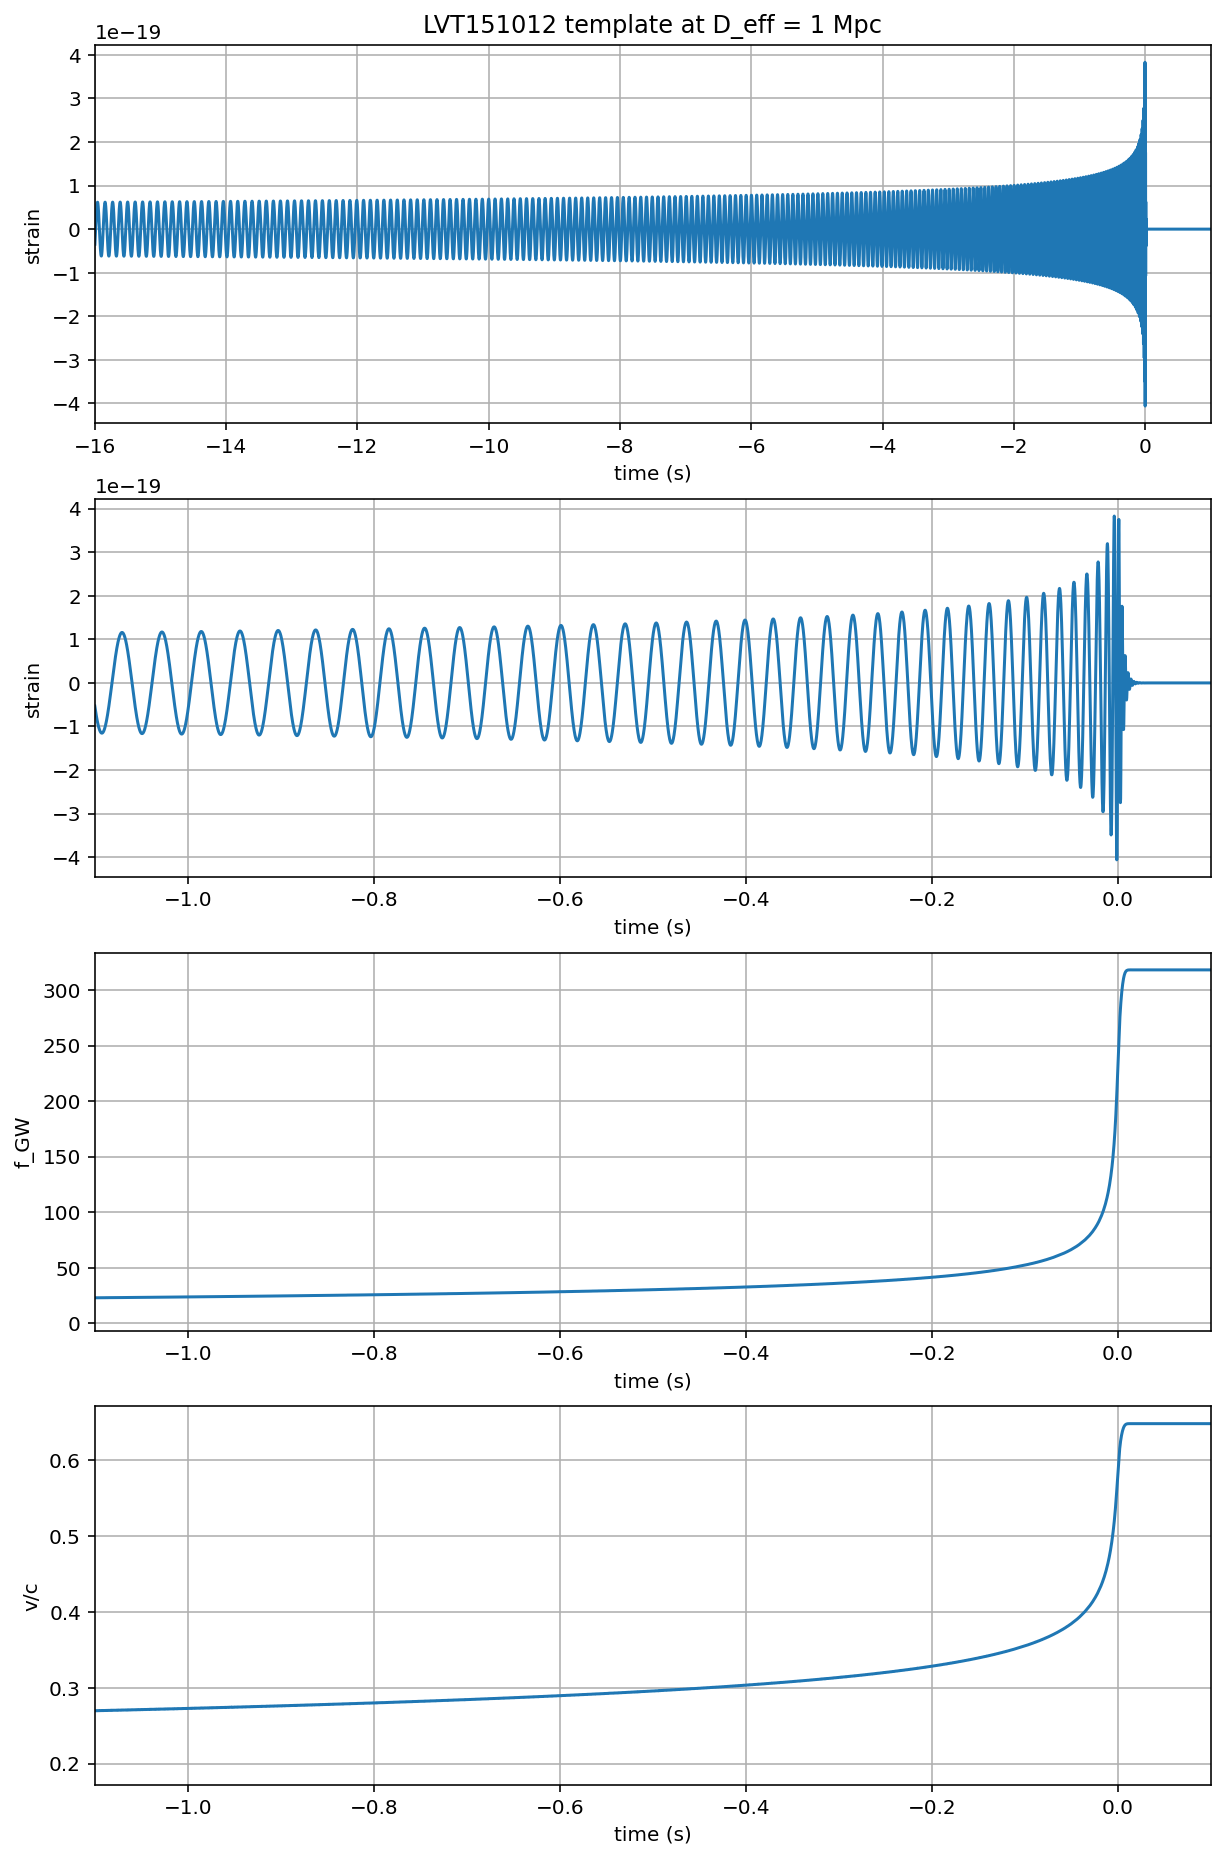

In [184]:
# extract metadata from the template file:
template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

# whiten the templates:
template_p_whiten = whiten(template_p,psd_H1,dt)
template_c_whiten = whiten(template_c,psd_H1,dt)
template_p_whitenbp = filtfilt(bb, ab, template_p_whiten) / normalization
template_c_whitenbp = filtfilt(bb, ab, template_c_whiten) / normalization

# Compute, print and plot some properties of the template:

# constants:
clight = 2.99792458e8                # m/s
G = 6.67259e-11                      # m^3/kg/s^2 
MSol = 1.989e30                      # kg

# template parameters: masses in units of MSol:
t_mtot = t_m1+t_m2
# final BH mass is typically 95% of the total initial mass:
t_mfin = t_mtot*0.95
# Final BH radius, in km:
R_fin = 2*G*t_mfin*MSol/clight**2/1000.

# complex template:
template = (template_p + template_c*1.j) 
ttime = time-time[0]-template_offset

# compute the instantaneous frequency of this chirp-like signal:
tphase = np.unwrap(np.angle(template))
fGW = np.gradient(tphase)*fs/(2.*np.pi)
# fix discontinuities at the very end:
# iffix = np.where(np.abs(np.gradient(fGW)) > 100.)[0]
iffix = np.where(np.abs(template) < np.abs(template).max()*0.001)[0]
fGW[iffix] = fGW[iffix[0]-1]
fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]

# compute v/c:
voverc = (G*t_mtot*MSol*np.pi*fGW/clight**3)**(1./3.)

# index where f_GW is in-band:
f_inband = fband[0]
iband = np.where(fGW > f_inband)[0][0]
# index at the peak of the waveform:
ipeak = np.argmax(np.abs(template))

# number of cycles between inband and peak:
Ncycles = (tphase[ipeak]-tphase[iband])/(2.*np.pi)

print('Properties of waveform template in {0}'.format(fn_template))
print("Waveform family = {0}".format(t_approx))
print("Masses = {0:.2f}, {1:.2f} Msun".format(t_m1,t_m2))
print('Mtot = {0:.2f} Msun, mfinal = {1:.2f} Msun '.format(t_mtot,t_mfin))
print("Spins = {0:.2f}, {1:.2f}".format(t_a1,t_a2))
print('Freq at inband, peak = {0:.2f}, {1:.2f} Hz'.format(fGW[iband],fGW[ipeak]))
print('Time at inband, peak = {0:.2f}, {1:.2f} s'.format(ttime[iband],ttime[ipeak]))
print('Duration (s) inband-peak = {0:.2f} s'.format(ttime[ipeak]-ttime[iband]))
print('N_cycles inband-peak = {0:.0f}'.format(Ncycles))
print('v/c at peak = {0:.2f}'.format(voverc[ipeak]))
print('Radius of final BH = {0:.0f} km'.format(R_fin))

if make_plots:
    plt.figure(figsize=(10,16))
    plt.subplot(4,1,1)
    plt.plot(ttime,template_p)
    plt.xlim([-template_offset,1.])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    plt.title(eventname+' template at D_eff = 1 Mpc')
    
    plt.subplot(4,1,2)
    plt.plot(ttime,template_p)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    #plt.title(eventname+' template at D_eff = 1 Mpc')
    
    plt.subplot(4,1,3)
    plt.plot(ttime,fGW)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('f_GW')
    #plt.title(eventname+' template f_GW')
    
    plt.subplot(4,1,4)
    plt.plot(ttime,voverc)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('v/c')
    #plt.title(eventname+' template v/c')
    plt.savefig(eventname+'_template.'+plottype)

Figure 7: Similar to Figure 5 above, with a different template.

For detector H1, maximum at 1128678900.4421 with SNR = 6.3, D_eff = 1577.90, horizon = 1241.5 Mpc
For detector L1, maximum at 1128678900.4429 with SNR = 6.1, D_eff = 1494.08, horizon = 1137.7 Mpc


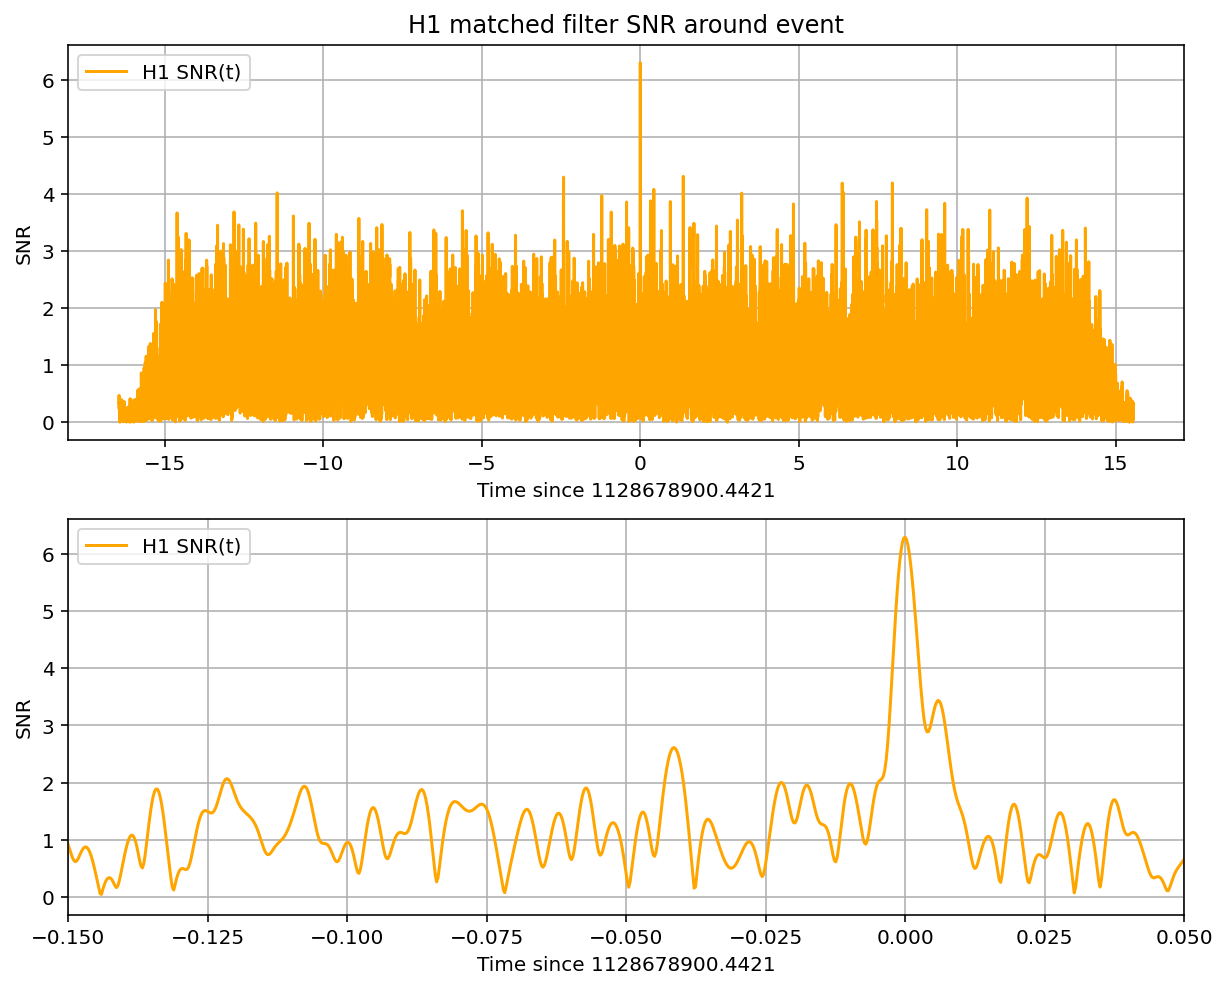

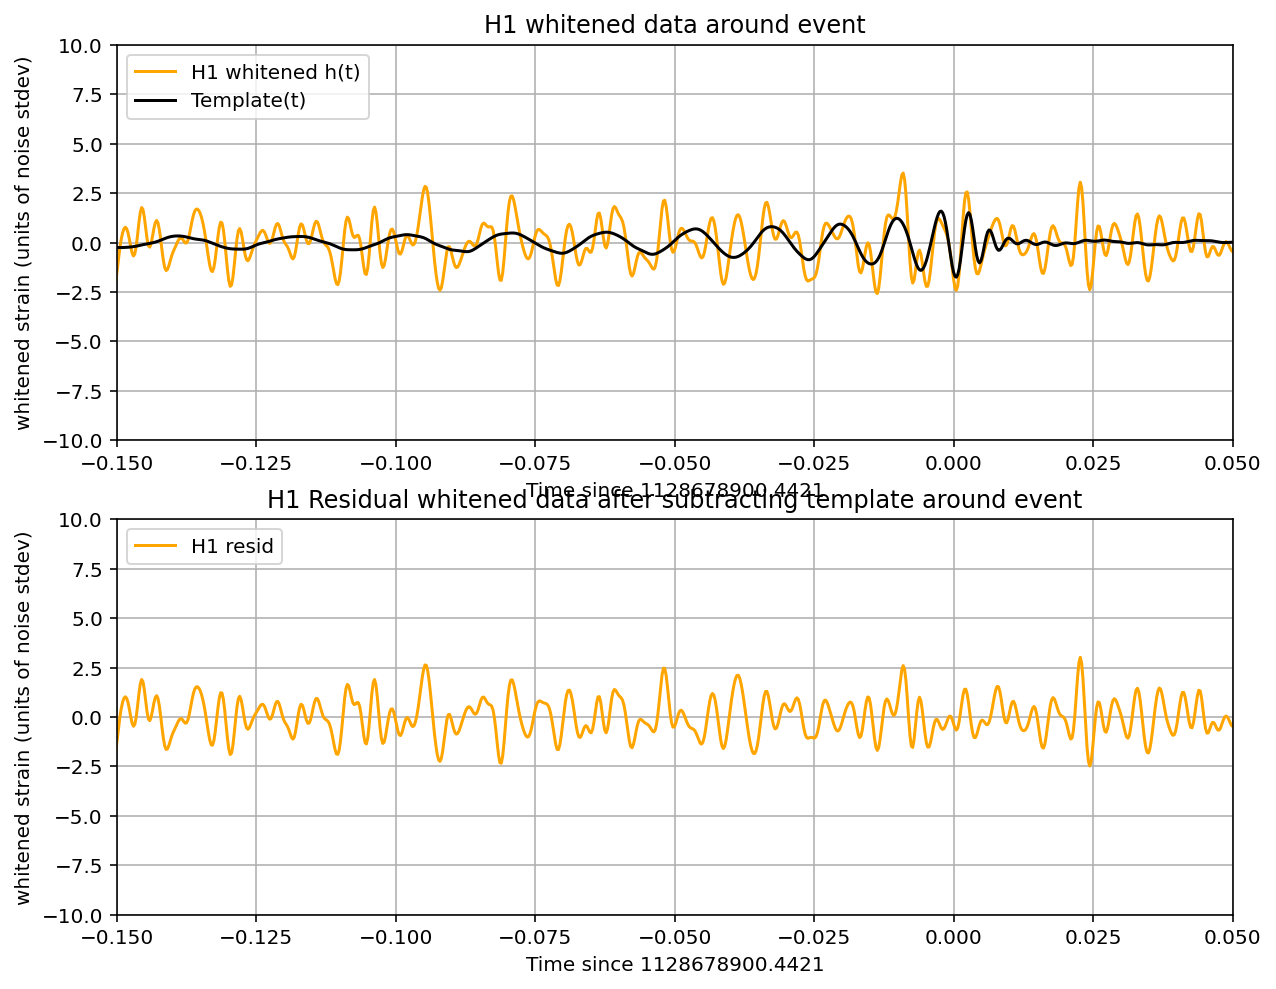

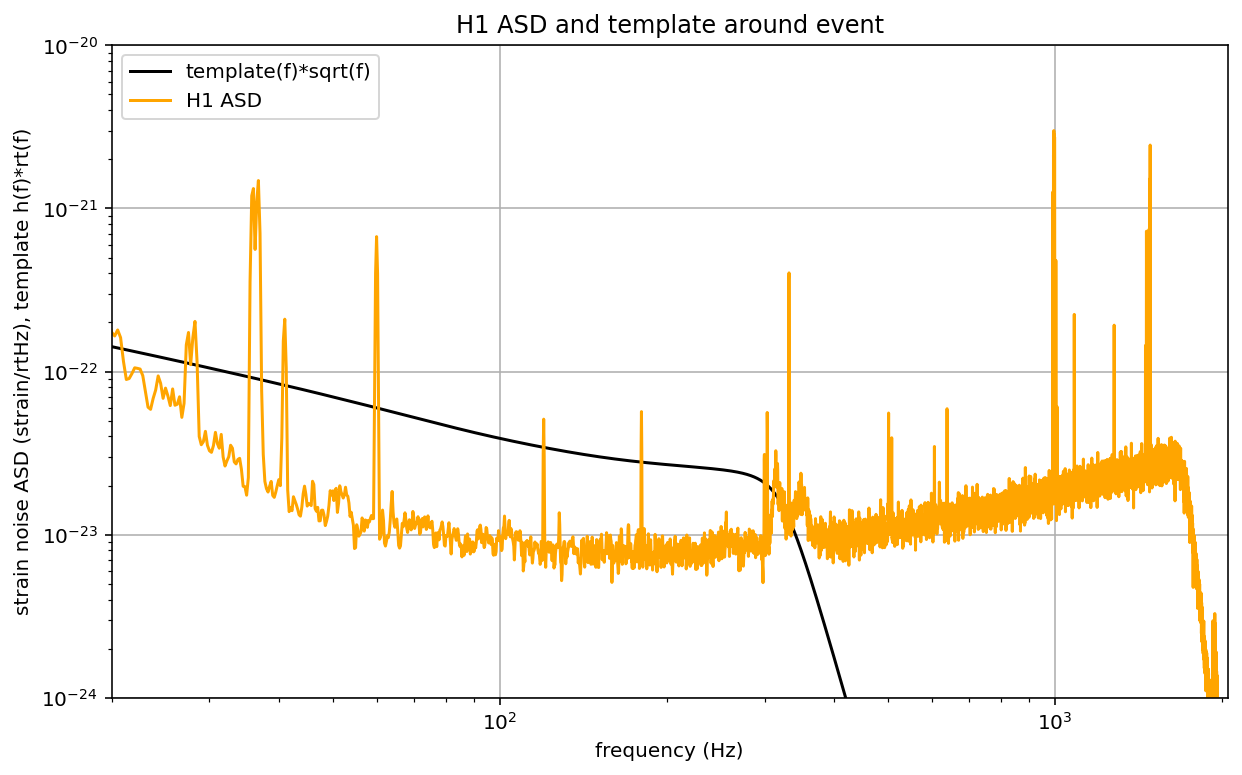

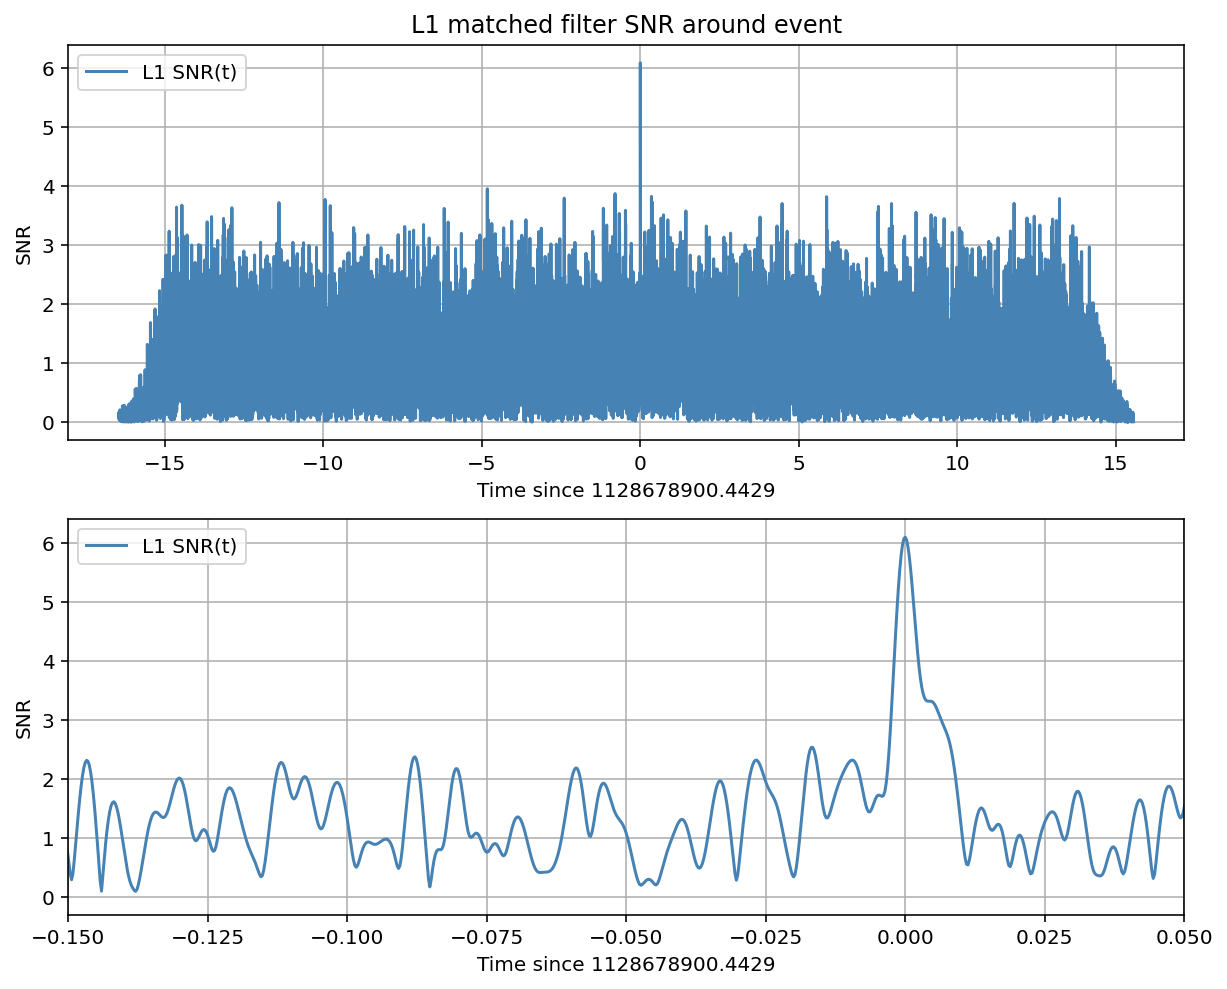

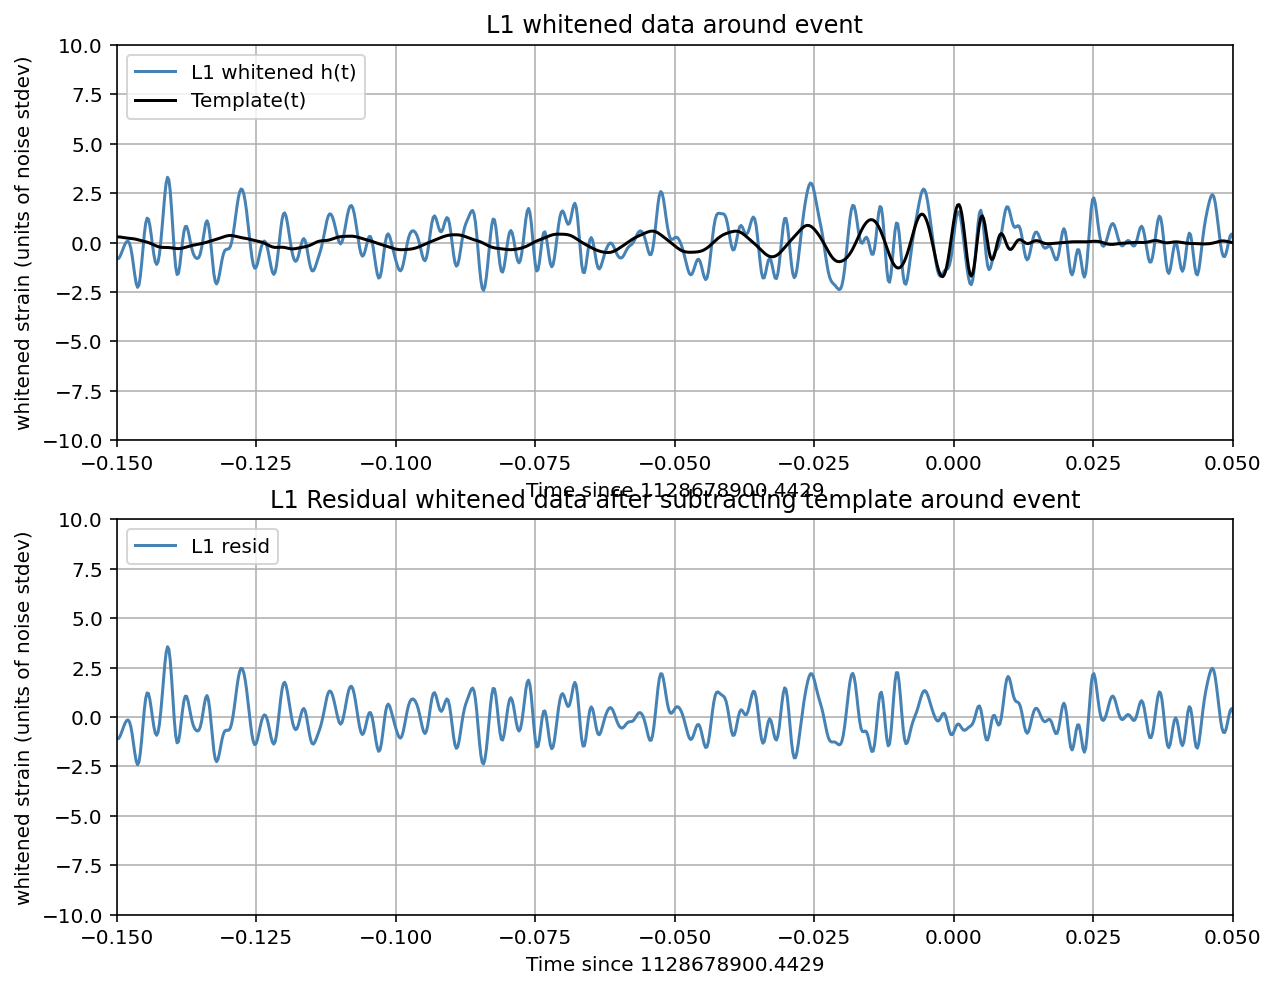

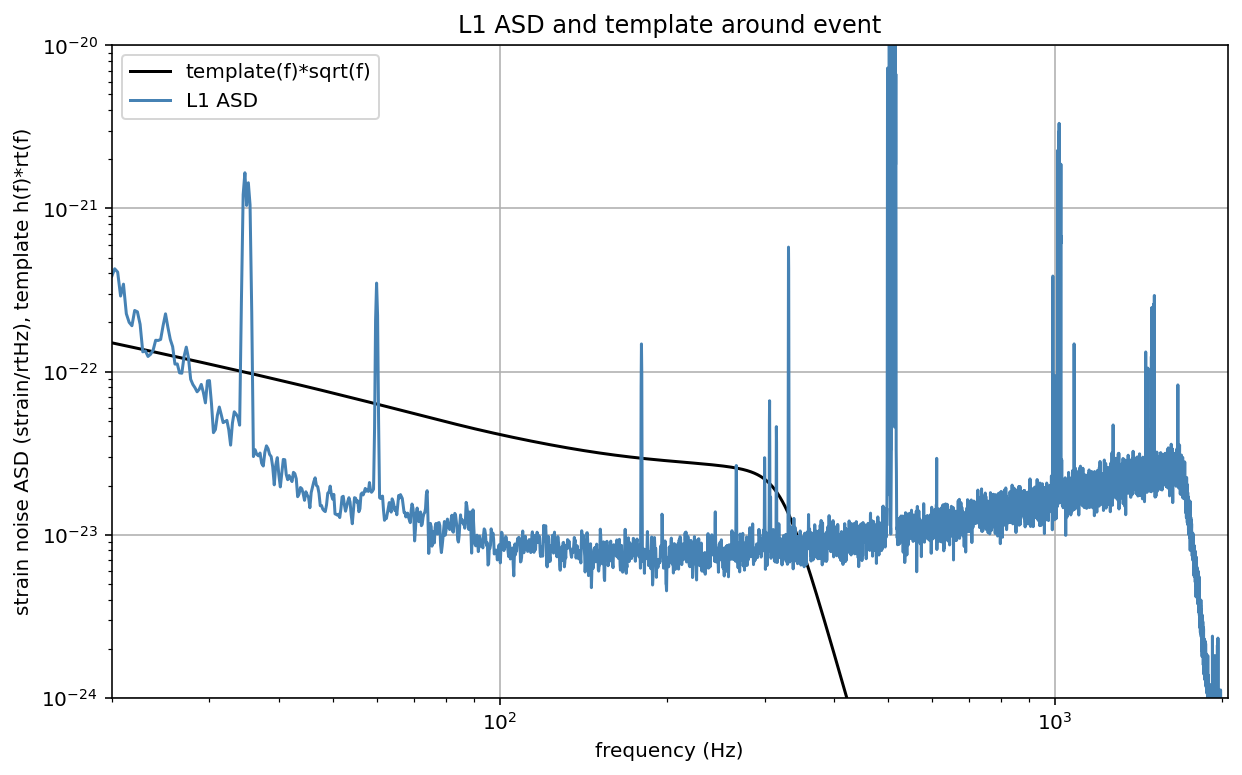

In [185]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(LIGOpath + "/" + fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()
    
# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# define the complex template, common to both detectors:
template = (template_p + template_c*1.j) 
# We will record the time where the data match the END of the template.
etime = time+template_offset
# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs

# loop over the detectors
dets = ['H1', 'L1']
for det in dets:

    if det is 'L1': data = strain_L1.copy()
    else:           data = strain_H1.copy()

    # -- Calculate the PSD of the data.  Also use an overlap, and window:
    data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(data*dwindow) / fs

    # -- Interpolate to get the PSD values at the needed frequencies
    power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = time[indmax]
    SNRmax = SNR[indmax]

    # Calculate the "effective distance" (see FINDCHIRP paper for definition)
    #  d_eff = (8. / SNRmax)*D_thresh
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)

    # apply time offset, phase, and d_eff to template 
    template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
    template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude
    
    # Whiten and band-pass the template for plotting
    template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
    template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template
    
    print('For detector {0}, maximum at {1:.4f} with SNR = {2:.1f}, D_eff = {3:.2f}, horizon = {4:0.1f} Mpc' 
          .format(det,timemax,SNRmax,d_eff,horizon))

    if make_plots:

        # plotting changes for the detectors:
        if det is 'L1': 
            pcolor='SteelBlue'
            strain_whitenbp = strain_L1_whitenbp
            template_L1 = template_match.copy()
        else:
            pcolor='Orange'
            strain_whitenbp = strain_H1_whitenbp
            template_H1 = template_match.copy()

        # -- Plot the result
        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.plot(time-timemax, SNR, pcolor,label=det+' SNR(t)')
        #plt.ylim([0,25.])
        plt.grid('on')
        plt.ylabel('SNR')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.legend(loc='upper left')
        plt.title(det+' matched filter SNR around event')

        # zoom in
        plt.subplot(2,1,2)
        plt.plot(time-timemax, SNR, pcolor,label=det+' SNR(t)')
        plt.grid('on')
        plt.ylabel('SNR')
        plt.xlim([-0.15,0.05])
        #plt.xlim([-0.3,+0.3])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.legend(loc='upper left')
        plt.savefig(eventname+"_"+det+"_SNR."+plottype)

        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.plot(time-tevent,strain_whitenbp,pcolor,label=det+' whitened h(t)')
        plt.plot(time-tevent,template_match,'k',label='Template(t)')
        plt.ylim([-10,10])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left')
        plt.title(det+' whitened data around event')

        plt.subplot(2,1,2)
        plt.plot(time-tevent,strain_whitenbp-template_match,pcolor,label=det+' resid')
        plt.ylim([-10,10])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left')
        plt.title(det+' Residual whitened data after subtracting template around event')
        plt.savefig(eventname+"_"+det+"_matchtime."+plottype)
                 
        # -- Display PSD and template
        # must multiply by sqrt(f) to plot template fft on top of ASD:
        plt.figure(figsize=(10,6))
        template_f = np.absolute(template_fft)*np.sqrt(np.abs(datafreq)) / d_eff
        plt.loglog(datafreq, template_f, 'k', label='template(f)*sqrt(f)')
        plt.loglog(freqs, np.sqrt(data_psd),pcolor, label=det+' ASD')
        plt.xlim(20, fs/2)
        plt.ylim(1e-24, 1e-20)
        plt.grid()
        plt.xlabel('frequency (Hz)')
        plt.ylabel('strain noise ASD (strain/rtHz), template h(f)*rt(f)')
        plt.legend(loc='upper left')
        plt.title(det+' ASD and template around event')
        plt.savefig(eventname+"_"+det+"_matchfreq."+plottype)


Figure 8: Similar to the analysis done in figure 8 for the GW150914 event, except with our new event.  Results clearly show the event detection, as in the previous case.